In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
def retrieve_records(start_dt, end_dt):
    sql_str = f"SELECT * FROM signals WHERE date BETWEEN '{start_dt}' AND '{end_dt}'"
    df_temp = pd.read_sql_query(sql_str, db_connector)
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    return df_temp


In [3]:

db_connector = sqlite3.connect('/Users/neelabhkashyap/Downloads/data.db')

train_start_date = '2000-01-01'
train_end_date = '2005-12-31'

train_df = retrieve_records(train_start_date, train_end_date)


In [4]:
class ReturnFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=63, window_ma=5, window_vol=10):
        
        self.period = period
        self.window_ma = window_ma
        self.window_vol = window_vol

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        df_enhanced = X.copy()
        
        df_enhanced = df_enhanced.sort_values(['symbol', 'date'])
        
        # 5-day moving average for momentum signal
        df_enhanced['ma_5day'] = df_enhanced.groupby('symbol')['close'].transform(lambda x: x.rolling(window=self.window_ma).mean())
        
        # Daily returns and 10-day rolling volatility
        df_enhanced['daily_return'] = df_enhanced.groupby('symbol')['close'].pct_change()
        df_enhanced['volatility_10day'] = df_enhanced.groupby('symbol')['daily_return'].transform(lambda x: x.rolling(window=self.window_vol).std())
        
        df_final = df_enhanced.fillna(0)
        
        return df_final[['ma_5day', 'volatility_10day']].values


In [5]:
train_df

,id,symbol,date,open,high,low,close,volume,adj_close,unadjusted_volume,...,ebitda,net_income_ttm,revenue_ttm,gross_profit_ttm,ebitda_ttm,operating_cash_flow,free_cash_flow,free_cash_flow_ttm,operating_cash_flow_ttm,market_cap
0,9307652,A,2000-01-03,53.060000,53.180000,45.390000,48.510000,4962189,43.450000,4962189,...,2.087000e+09,366000000.0,5.883000e+09,5.883000e+09,5.883000e+09,NaN,NaN,NaN,NaN,2.129589e+10
1,31153052,AAIC,2000-01-03,155.000000,155.000000,140.000000,142.500000,2770,24.392216,2770,...,1.120000e+07,-7100000.0,1.505000e+08,1.505000e+08,1.920000e+07,5400000.0,2100000.0,-5900000.0,1500000.0,3.492746e+08
2,21134674,AAME,2000-01-03,2.380000,2.440000,2.250000,2.310000,5100,2.070000,5100,...,0.000000e+00,3758000.0,1.154660e+08,1.154660e+08,5.188000e+06,1600000.0,-17100000.0,-11219000.0,7975000.0,4.853772e+07
3,13926701,AAON,2000-01-03,0.863310,0.863310,0.790140,0.790140,1026865,0.653790,1026865,...,5.423000e+06,8441000.0,1.242290e+08,2.969100e+07,1.713000e+07,1861000.0,-363000.0,6153000.0,11244000.0,5.617018e+07
4,6231,AAPL,2000-01-03,0.936380,1.000000,0.907920,0.999440,535819955,0.844000,535819955,...,1.490000e+08,601000000.0,6.134000e+09,1.696000e+09,4.450000e+08,218000000.0,202000000.0,751000000.0,798000000.0,1.802621e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238527,22018137,ZBRA,2005-12-30,42.800000,43.120000,42.700000,42.850000,263204,42.849998,263300,...,4.116100e+07,111301000.0,6.978510e+08,3.552850e+08,1.678890e+08,41687000.0,39058000.0,97267000.0,112448000.0,3.053620e+09
2238528,21919291,ZD,2005-12-30,19.004349,19.004349,18.134783,18.582609,1535250,15.462739,1535250,...,1.786400e+07,49374000.0,1.345970e+08,1.086350e+08,6.216300e+07,15951000.0,13518000.0,49516000.0,59725000.0,9.057113e+08
2238529,23244822,ZEUS,2005-12-30,24.850000,25.020000,24.790000,24.850000,78600,21.910000,78600,...,4.825000e+06,26946000.0,9.746070e+08,1.715150e+08,5.069500e+07,70760000.0,69971000.0,78488000.0,80514000.0,2.523020e+08
2238530,21320566,ZION,2005-12-30,75.930000,76.250000,75.270000,75.560000,407865,53.490000,407865,...,0.000000e+00,456995000.0,1.715659e+09,1.715659e+09,0.000000e+00,-14448000.0,-14448000.0,423254000.0,478645000.0,6.798889e+09


In [6]:
train_df['return_3mo'] = train_df.groupby('symbol')['close'].pct_change(periods=63)
train_df['return_3mo'] = train_df.groupby('symbol')['return_3mo'].transform(
    lambda x: x.fillna(method='bfill')
)
train_df

,id,symbol,date,open,high,low,close,volume,adj_close,unadjusted_volume,...,net_income_ttm,revenue_ttm,gross_profit_ttm,ebitda_ttm,operating_cash_flow,free_cash_flow,free_cash_flow_ttm,operating_cash_flow_ttm,market_cap,return_3mo
0,9307652,A,2000-01-03,53.060000,53.180000,45.390000,48.510000,4962189,43.450000,4962189,...,366000000.0,5.883000e+09,5.883000e+09,5.883000e+09,NaN,NaN,NaN,NaN,2.129589e+10,0.361163
1,31153052,AAIC,2000-01-03,155.000000,155.000000,140.000000,142.500000,2770,24.392216,2770,...,-7100000.0,1.505000e+08,1.505000e+08,1.920000e+07,5400000.0,2100000.0,-5900000.0,1500000.0,3.492746e+08,0.438596
2,21134674,AAME,2000-01-03,2.380000,2.440000,2.250000,2.310000,5100,2.070000,5100,...,3758000.0,1.154660e+08,1.154660e+08,5.188000e+06,1600000.0,-17100000.0,-11219000.0,7975000.0,4.853772e+07,0.138528
3,13926701,AAON,2000-01-03,0.863310,0.863310,0.790140,0.790140,1026865,0.653790,1026865,...,8441000.0,1.242290e+08,2.969100e+07,1.713000e+07,1861000.0,-363000.0,6153000.0,11244000.0,5.617018e+07,0.290910
4,6231,AAPL,2000-01-03,0.936380,1.000000,0.907920,0.999440,535819955,0.844000,535819955,...,601000000.0,6.134000e+09,1.696000e+09,4.450000e+08,218000000.0,202000000.0,751000000.0,798000000.0,1.802621e+10,0.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238527,22018137,ZBRA,2005-12-30,42.800000,43.120000,42.700000,42.850000,263204,42.849998,263300,...,111301000.0,6.978510e+08,3.552850e+08,1.678890e+08,41687000.0,39058000.0,97267000.0,112448000.0,3.053620e+09,0.096188
2238528,21919291,ZD,2005-12-30,19.004349,19.004349,18.134783,18.582609,1535250,15.462739,1535250,...,49374000.0,1.345970e+08,1.086350e+08,6.216300e+07,15951000.0,13518000.0,49516000.0,59725000.0,9.057113e+08,0.057397
2238529,23244822,ZEUS,2005-12-30,24.850000,25.020000,24.790000,24.850000,78600,21.910000,78600,...,26946000.0,9.746070e+08,1.715150e+08,5.069500e+07,70760000.0,69971000.0,78488000.0,80514000.0,2.523020e+08,0.422438
2238530,21320566,ZION,2005-12-30,75.930000,76.250000,75.270000,75.560000,407865,53.490000,407865,...,456995000.0,1.715659e+09,1.715659e+09,0.000000e+00,-14448000.0,-14448000.0,423254000.0,478645000.0,6.798889e+09,0.060938


In [7]:
X_train = train_df
X_train = X_train.reset_index(drop=False)
if 'symbol' in X_train.columns:
    X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_train = X_train.groupby('symbol').apply(lambda group: group.bfill())

In [8]:
X_train = X_train.reset_index(drop=True)
if 'symbol' in X_train.columns:
    X_train = X_train.loc[:, ~X_train.columns.duplicated()]



In [9]:
X_train = X_train.sort_values(by=['date', 'symbol'])
X_train

,index,id,symbol,date,open,high,low,close,volume,adj_close,...,net_income_ttm,revenue_ttm,gross_profit_ttm,ebitda_ttm,operating_cash_flow,free_cash_flow,free_cash_flow_ttm,operating_cash_flow_ttm,market_cap,return_3mo
0,0,9307652,A,2000-01-03,53.060000,53.180000,45.390000,48.510000,4962189,43.450000,...,366000000.0,5.883000e+09,5.883000e+09,5.883000e+09,384000000.0,293000000.0,293000000.0,384000000.0,2.129589e+10,0.361163
1508,1,31153052,AAIC,2000-01-03,155.000000,155.000000,140.000000,142.500000,2770,24.392216,...,-7100000.0,1.505000e+08,1.505000e+08,1.920000e+07,5400000.0,2100000.0,-5900000.0,1500000.0,3.492746e+08,0.438596
2966,2,21134674,AAME,2000-01-03,2.380000,2.440000,2.250000,2.310000,5100,2.070000,...,3758000.0,1.154660e+08,1.154660e+08,5.188000e+06,1600000.0,-17100000.0,-11219000.0,7975000.0,4.853772e+07,0.138528
4002,3,13926701,AAON,2000-01-03,0.863310,0.863310,0.790140,0.790140,1026865,0.653790,...,8441000.0,1.242290e+08,2.969100e+07,1.713000e+07,1861000.0,-363000.0,6153000.0,11244000.0,5.617018e+07,0.290910
6539,4,6231,AAPL,2000-01-03,0.936380,1.000000,0.907920,0.999440,535819955,0.844000,...,601000000.0,6.134000e+09,1.696000e+09,4.450000e+08,218000000.0,202000000.0,751000000.0,798000000.0,1.802621e+10,0.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234065,2238527,22018137,ZBRA,2005-12-30,42.800000,43.120000,42.700000,42.850000,263204,42.849998,...,111301000.0,6.978510e+08,3.552850e+08,1.678890e+08,41687000.0,39058000.0,97267000.0,112448000.0,3.053620e+09,0.096188
2235418,2238528,21919291,ZD,2005-12-30,19.004349,19.004349,18.134783,18.582609,1535250,15.462739,...,49374000.0,1.345970e+08,1.086350e+08,6.216300e+07,15951000.0,13518000.0,49516000.0,59725000.0,9.057113e+08,0.057397
2236857,2238529,23244822,ZEUS,2005-12-30,24.850000,25.020000,24.790000,24.850000,78600,21.910000,...,26946000.0,9.746070e+08,1.715150e+08,5.069500e+07,70760000.0,69971000.0,78488000.0,80514000.0,2.523020e+08,0.422438
2238365,2238530,21320566,ZION,2005-12-30,75.930000,76.250000,75.270000,75.560000,407865,53.490000,...,456995000.0,1.715659e+09,1.715659e+09,0.000000e+00,-14448000.0,-14448000.0,423254000.0,478645000.0,6.798889e+09,0.060938


In [10]:
X_train.shape

(2238532, 36)

In [11]:
y_train = X_train['return_3mo']
y_train.shape

(2238532,)

In [12]:
y_train_final = y_train.fillna(0)
y_train_final.isna().sum()

0

In [13]:
# Pipeline that first creates engineered features then scales, reduces dimensionality, and fits a linear model.
enhanced_pipeline = Pipeline(steps=[
    ('feature_trans', ReturnFeatureTransformer()),
    ('data_scaler', StandardScaler()),
    ('pca_reducer', PCA(n_components=0.95)),
    ('lin_reg', LinearRegression())
])


X_train_final = X_train.drop(columns=['return_3mo'])

enhanced_pipeline.fit(X_train_final, y_train_final)

print(enhanced_pipeline)


Pipeline(steps=[('feature_trans', ReturnFeatureTransformer()),
                ('data_scaler', StandardScaler()),
                ('pca_reducer', PCA(n_components=0.95)),
                ('lin_reg', LinearRegression())])


In [14]:
def retrain_model(model, current_date):
    train_end = (current_date - timedelta(days=90)).strftime('%Y-%m-%d')
    train_start = (current_date - timedelta(days=365 + 90)).strftime('%Y-%m-%d')  # 1 year + 3 months buffer
    train_data = retrieve_records(train_start, train_end)
    train_data['return_3mo'] = train_data.groupby('symbol')['close'].transform(
        lambda x: x.pct_change(periods=63)
    )

    train_data_final = train_data.fillna(0)
    
    X = train_data_final.drop(columns=['return_3mo'])
    y = train_data_final['return_3mo']
    model.fit(X, y)
    if current_date.month % 6 == 0:
        model_filename = f"model_{current_date.strftime('%Y%m%d')}.pkl"
        joblib.dump(model, model_filename)
        print(f"Retrained model saved as {model_filename}")
    
    return model

In [15]:
import pandas as pd
from datetime import timedelta

# Function to retrieve the data
def get_stock_data(current_date):
    current_data = retrieve_records(current_date.strftime('%Y-%m-%d'), (current_date + pd.DateOffset(months=1)).strftime('%Y-%m-%d'))
    current_data = current_data.fillna(0)
    #print(current_data.mean)
    return current_data

def update_model(current_date, model):
    if current_date.month % 6 == 0 and current_date.day == 1:
        return retrain_model(model, current_date)
    return model

# Function to select top-ranked stocks based on predicted returns
def select_top_stocks(current_data, model, positions, cash, current_date):
    #print(current_data.columns)
    if not current_data.empty:
        current_data['predicted_return'] = model.predict(current_data)
        stock_returns = current_data.groupby('symbol')['predicted_return'].mean().reset_index()
        ranked_stocks = stock_returns.sort_values(by='predicted_return', ascending=False).head(100)
        
        for stock in ranked_stocks['symbol']:
            if stock not in positions:
                buy_price = current_data[current_data['symbol'] == stock]['close'].values[0]
                if not current_data.empty:
                    positions[stock] = {
                        'investment_date': current_date,
                        'amount': 10000,
                        'buy_price': buy_price
                    }
                    cash -= 10000 
    return positions, cash

# Function to handle position selling after 3 months
def sell_positions(current_date, positions, stock_data, cash):
    for stock in list(positions.keys()):
        if current_date >= positions[stock]['investment_date'] + timedelta(days=90):
            if stock in stock_data['symbol'].values:
                sell_price = stock_data[stock_data['symbol'] == stock]['close'].values[0]
                cash += positions[stock]['amount'] * (1 + (sell_price - positions[stock]['buy_price']) / positions[stock]['buy_price'])
                del positions[stock]
    return positions, cash

# Function to mark unsold positions at the end of the test period
def mark_to_market_end_of_period(current_date, test_end, positions, stock_data, cash):
    if current_date == test_end:
        for stock in positions:
            if stock in stock_data['symbol'].values:
                sell_price = stock_data[stock_data['symbol'] == stock]['close'].values[0]
                cash += positions[stock]['amount'] * (1 + (sell_price - positions[stock]['buy_price']) / positions[stock]['buy_price'])
    return cash

# Function to calculate the portfolio value
def calculate_portfolio_value(positions, cash, stock_data):
    current_portfolio_value = cash
    for stock in positions:
        if stock in stock_data['symbol'].values:
            current_price = stock_data[stock_data['symbol'] == stock]['close'].values[0]
            current_portfolio_value += positions[stock]['amount'] * (1 + (current_price) / positions[stock]['buy_price'])
    return current_portfolio_value

# Main simulation function
def simulate_portfolio(initial_investment=1000000, test_start='2006-04-01', test_end='2024-12-31'):
    portfolio_value = []
    cash = initial_investment 
    positions = {}  
    model = enhanced_pipeline 
    current_date = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    
    while current_date <= test_end:
        # Update model on the first trading day of each quarter 
        model = update_model(current_date, model)
        #print("update model")
        
        current_data = get_stock_data(current_date)
        #print("current data")
        
        positions, cash = select_top_stocks(current_data, model, positions, cash, current_date)
        #print("select top stocks")

        positions, cash = sell_positions(current_date, positions, current_data, cash)
        #print("sell positions")

        cash = mark_to_market_end_of_period(current_date, test_end, positions, current_data, cash)
        #print("mark to market")

        current_portfolio_value = calculate_portfolio_value(positions, cash, current_data)
        portfolio_value.append(current_portfolio_value)
        
        # Move to the next month
        current_date += pd.DateOffset(months=1)
        print(f" Trading month {current_date} completed")

    return portfolio_value

# Run the simulation
portfolio_values = simulate_portfolio()


 Trading month 2006-05-01 00:00:00 completed
 Trading month 2006-06-01 00:00:00 completed
Retrained model saved as model_20060601.pkl
 Trading month 2006-07-01 00:00:00 completed
 Trading month 2006-08-01 00:00:00 completed
 Trading month 2006-09-01 00:00:00 completed
 Trading month 2006-10-01 00:00:00 completed
 Trading month 2006-11-01 00:00:00 completed
 Trading month 2006-12-01 00:00:00 completed
Retrained model saved as model_20061201.pkl
 Trading month 2007-01-01 00:00:00 completed
 Trading month 2007-02-01 00:00:00 completed
 Trading month 2007-03-01 00:00:00 completed
 Trading month 2007-04-01 00:00:00 completed
 Trading month 2007-05-01 00:00:00 completed
 Trading month 2007-06-01 00:00:00 completed
Retrained model saved as model_20070601.pkl
 Trading month 2007-07-01 00:00:00 completed
 Trading month 2007-08-01 00:00:00 completed
 Trading month 2007-09-01 00:00:00 completed
 Trading month 2007-10-01 00:00:00 completed
 Trading month 2007-11-01 00:00:00 completed
 Trading mont

 Trading month 2019-06-01 00:00:00 completed
Retrained model saved as model_20190601.pkl
 Trading month 2019-07-01 00:00:00 completed
 Trading month 2019-08-01 00:00:00 completed
 Trading month 2019-09-01 00:00:00 completed
 Trading month 2019-10-01 00:00:00 completed
 Trading month 2019-11-01 00:00:00 completed
 Trading month 2019-12-01 00:00:00 completed
Retrained model saved as model_20191201.pkl
 Trading month 2020-01-01 00:00:00 completed
 Trading month 2020-02-01 00:00:00 completed
 Trading month 2020-03-01 00:00:00 completed
 Trading month 2020-04-01 00:00:00 completed
 Trading month 2020-05-01 00:00:00 completed
 Trading month 2020-06-01 00:00:00 completed
Retrained model saved as model_20200601.pkl
 Trading month 2020-07-01 00:00:00 completed
 Trading month 2020-08-01 00:00:00 completed
 Trading month 2020-09-01 00:00:00 completed
 Trading month 2020-10-01 00:00:00 completed
 Trading month 2020-11-01 00:00:00 completed
 Trading month 2020-12-01 00:00:00 completed
Retrained mod

Total PnL: $21,567,104.44
Max Drawdown: -54.40%
Annualized Return (CAGR): 14.11%
Sharpe Ratio: 0.37


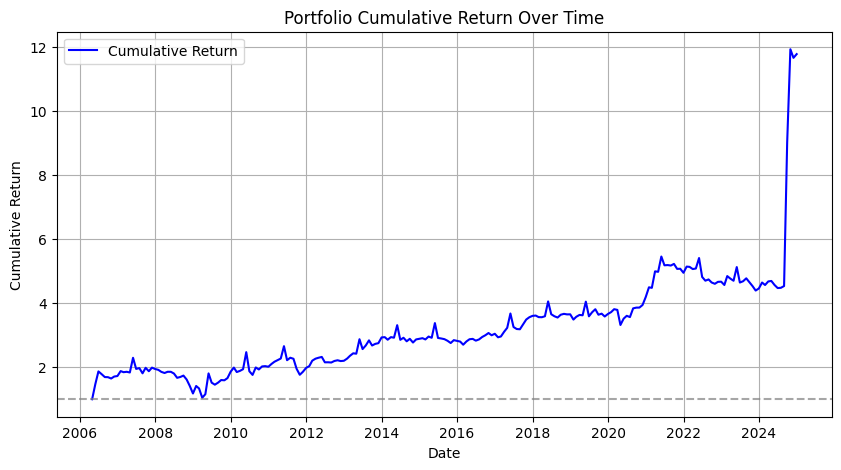

In [16]:

dates = pd.date_range(start="2006-04-01", periods=len(portfolio_values), freq='M')

# Check if portfolio_value is not empty
if len(portfolio_values) == 0:
    raise ValueError("Portfolio value data is empty. Please provide valid data.")

# Total Dollars PnL
total_capital_invested = 1000000 * len(portfolio_values)  # Assuming $1M invested per month
final_portfolio_value = portfolio_values[-1]
total_pnl = final_portfolio_value - portfolio_values[0]

print(f"Total PnL: ${total_pnl:,.2f}")

# Max Drawdown Calculation
cumulative_max = np.maximum.accumulate(portfolio_values)
drawdown = (portfolio_values - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

print(f"Max Drawdown: {max_drawdown:.2%}")

# Annualized Return (CAGR)
years = (dates[-1] - dates[0]).days / 365
cagr = (final_portfolio_value / portfolio_values[0]) ** (1 / years) - 1

print(f"Annualized Return (CAGR): {cagr:.2%}")

# Sharpe Ratio Calculation
risk_free_rate = 0.05  # Assume 5% risk-free rate 
returns = np.diff(portfolio_values) / portfolio_values[:-1] 

if returns.std() > 0:
    sharpe_ratio = (returns.mean() - risk_free_rate / 12) / returns.std() * np.sqrt(12)  # Annualized
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
else:
    print("Sharpe Ratio: Cannot be calculated due to zero standard deviation of returns.")

# Plot Cumulative Return
cumulative_return = portfolio_values / portfolio_values[0]  # Normalize to 1.0
plt.figure(figsize=(10, 5))
plt.plot(dates, cumulative_return, label="Cumulative Return", color="blue")
plt.axhline(1.0, color="gray", linestyle="--", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Portfolio Cumulative Return Over Time")
plt.legend()
plt.grid(True)
plt.show()
